### Libraries

In [7]:
import numpy as np
import pandas as pd
import pandas_datareader as web
import cvxopt as opt
from cvxopt import blas, solvers
from datetime import datetime
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

### Optimization Functions (Copy from Codecademy course)

In [8]:
#Return Portfolio Function
def return_portfolios(expected_returns, cov_matrix):
    np.random.seed(1)
    port_returns = []
    port_volatility = []
    stock_weights = []
    
    selected = (expected_returns.axes)[0]
    
    num_assets = len(selected) 
    num_portfolios = 5000
    
    for single_portfolio in range(num_portfolios):
        weights = np.random.random(num_assets)
        weights /= np.sum(weights)
        returns = np.dot(weights, expected_returns)
        volatility = np.sqrt(np.dot(weights.T, np.dot(cov_matrix, weights)))
        port_returns.append(returns)
        port_volatility.append(volatility)
        stock_weights.append(weights)
    
        portfolio = {'Returns': port_returns,
                 'Volatility': port_volatility}
    
    for counter,symbol in enumerate(selected):
        portfolio[symbol +' Weight'] = [Weight[counter] for Weight in stock_weights]
    
    df = pd.DataFrame(portfolio)
    
    column_order = ['Returns', 'Volatility'] + [stock+' Weight' for stock in selected]
    
    df = df[column_order]
   
    return df

In [9]:
#Optimal Portfolio Function
def optimal_portfolio(returns):
    n = returns.shape[1]
    returns = np.transpose(returns.values)

    N = 10
    mus = [10**(5.0 * t/N - 1.0) for t in range(N)]

    # Convert to cvxopt matrices
    S = opt.matrix(np.cov(returns))
    pbar = opt.matrix(np.mean(returns, axis=1))

    # Create constraint matrices
    G = -opt.matrix(np.eye(n))   # negative n x n identity matrix
    h = opt.matrix(0.0, (n ,1))
    A = opt.matrix(1.0, (1, n))
    b = opt.matrix(1.0)

    # Calculate efficient frontier weights using quadratic programming
    portfolios = [solvers.qp(mu*S, -pbar, G, h, A, b)['x'] for mu in mus]
    
    ## CALCULATE RISKS AND RETURNS FOR FRONTIER
    returns = [blas.dot(pbar, x) for x in portfolios]
    risks = [np.sqrt(blas.dot(x, S*x)) for x in portfolios]
    ## CALCULATE THE 2ND DEGREE POLYNOMIAL OF THE FRONTIER CURVE
    m1 = np.polyfit(returns, risks, 2)
    x1 = np.sqrt(m1[2] / m1[0])
    # CALCULATE THE OPTIMAL PORTFOLIO
    wt = solvers.qp(opt.matrix(x1 * S), -pbar, G, h, A, b)['x']
    return np.asarray(wt), returns, risks

### Chosen Assets and Analysis period

In [10]:
#Assets: JP Morgan, Nestle, Amazon, Tesla, Disney ,Coca Cola, Toyota, Nike, IBM y Booking]
name_stocks = ['JPM','NSRGF','AMZN','TSLA','DIS','KO','TOYOF','NKE','IBM','BKNG']
full_name_stocks = ['JP Morgan', 'Nestle', 'Amazon', 'Tesla', 'Disney' ,'Coca Cola', 'Toyota', 'Nike', 'IBM', 'Booking']

In [11]:
# Time Period Analize: From March 15th to August 14th. 
start = datetime(2020,3,15)
end = datetime(2020,8,14)

### Data import

In [12]:
# Import dataset from yahoo finance
stock_df = web.DataReader(name_stocks,'yahoo', start, end)
stock_df.head()

Attributes  Adj Close                                                 \
Symbols           JPM      NSRGF         AMZN        TSLA        DIS   
Date                                                                   
2020-03-16  86.607307  89.614296  1689.150024  445.070007  95.010002   
2020-03-17  91.900200  94.964256  1807.839966  430.200012  93.529999   
2020-03-18  82.225975  92.771645  1830.000000  361.220001  88.800003   
2020-03-19  83.608009  96.240845  1880.930054  427.640015  94.930000   
2020-03-20  81.843719  93.989761  1846.089966  427.529999  85.980003   

Attributes                                                            ...  \
Symbols            KO      TOYOF        NKE         IBM         BKNG  ...   
Date                                                                  ...   
2020-03-16  44.852516  56.020000  66.623810   96.505226  1289.670044  ...   
2020-03-17  46.755234  59.150002  69.666214  103.878502  1368.260010  ...   
2020-03-18  44.446209  56.970001  67.870697  100.859062  1233.750000  ...   
2020-03-19  41.453403  59.000000  70.164970   97.732468  1191.479980  ...   
2020-03-20  37.955181  60.000000  67.282158   92.911110  1177.430054  ...   

Attributes      Volume                                               \
Symbols            JPM    NSRGF        AMZN        TSLA         DIS   
Date                                                                  
2020-03-16  38589700.0  69200.0   8917300.0  20489500.0  35379500.0   
2020-03-17  35239800.0  24500.0  10917100.0  23994600.0  27526200.0   
2020-03-18  41525600.0  12100.0   9645200.0  23786200.0  43592500.0   
2020-03-19  32175100.0  13900.0  10399900.0  30195500.0  30866800.0   
2020-03-20  30150800.0  18200.0   9817900.0  28285500.0  31957800.0   

Attributes                                                          
Symbols             KO    TOYOF         NKE         IBM       BKNG  
Date                                                                
2020-03-16  28682300.0    600.0  17976700.0  10568000.0   986900.0  
2020-03-17  32106700.0   8100.0  17122100.0   9258300.0  1080100.0  
2020-03-18  35408300.0  37900.0  19498800.0   8772500.0   933400.0  
2020-03-19  41956900.0  98000.0  16177200.0   8396500.0   980600.0  
2020-03-20  51513500.0   1300.0  15761900.0  10546500.0  1146500.0  

[5 rows x 60 columns]

In [13]:
# Transform the dataset to take only the 'Adj Close Price'. 
stock_adj_close = stock_df['Adj Close']
stock_adj_close.head()

Symbols,JPM,NSRGF,AMZN,TSLA,DIS,KO,TOYOF,NKE,IBM,BKNG
Date,,,,,,,,,,
2020-03-16,86.607307,89.614296,1689.150024,445.070007,95.010002,44.852516,56.020000,66.623810,96.505226,1289.670044
2020-03-17,91.900200,94.964256,1807.839966,430.200012,93.529999,46.755234,59.150002,69.666214,103.878502,1368.260010
2020-03-18,82.225975,92.771645,1830.000000,361.220001,88.800003,44.446209,56.970001,67.870697,100.859062,1233.750000
2020-03-19,83.608009,96.240845,1880.930054,427.640015,94.930000,41.453403,59.000000,70.164970,97.732468,1191.479980
2020-03-20,81.843719,93.989761,1846.089966,427.529999,85.980003,37.955181,60.000000,67.282158,92.911110,1177.430054


### Adj prices stock chart over the time

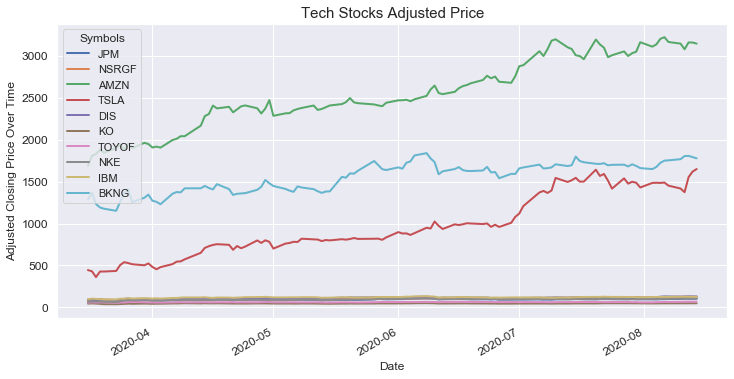

In [14]:
# Figure with Tech Stocks Price over the time
stock_adj_close.plot(figsize=(12,6),linewidth=2, grid=True, fontsize=12)
plt.xlabel("Date",fontsize=12)
plt.ylabel("Adjusted Closing Price Over Time",fontsize=12)
plt.title("Tech Stocks Adjusted Price",fontsize=15)
plt.show()

### Rate Return, Variance, Standard Deviation, Covariance Matrix and Correlation Matrix

In [15]:
# Rate Return by stock
daily_stock_return =  stock_adj_close.pct_change()
daily_stock_return.head()

Symbols,JPM,NSRGF,AMZN,TSLA,DIS,KO,TOYOF,NKE,IBM,BKNG
Date,,,,,,,,,,
2020-03-16,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2020-03-17,0.061114,0.059700,0.070266,-0.033410,-0.015577,0.042422,0.055873,0.045665,0.076403,0.060938
2020-03-18,-0.105269,-0.023089,0.012258,-0.160344,-0.050572,-0.049385,-0.036855,-0.025773,-0.029067,-0.098307
2020-03-19,0.016808,0.037395,0.027831,0.183877,0.069031,-0.067335,0.035633,0.033804,-0.031000,-0.034261
2020-03-20,-0.021102,-0.023390,-0.018523,-0.000257,-0.094280,-0.084389,0.016949,-0.041086,-0.049332,-0.011792


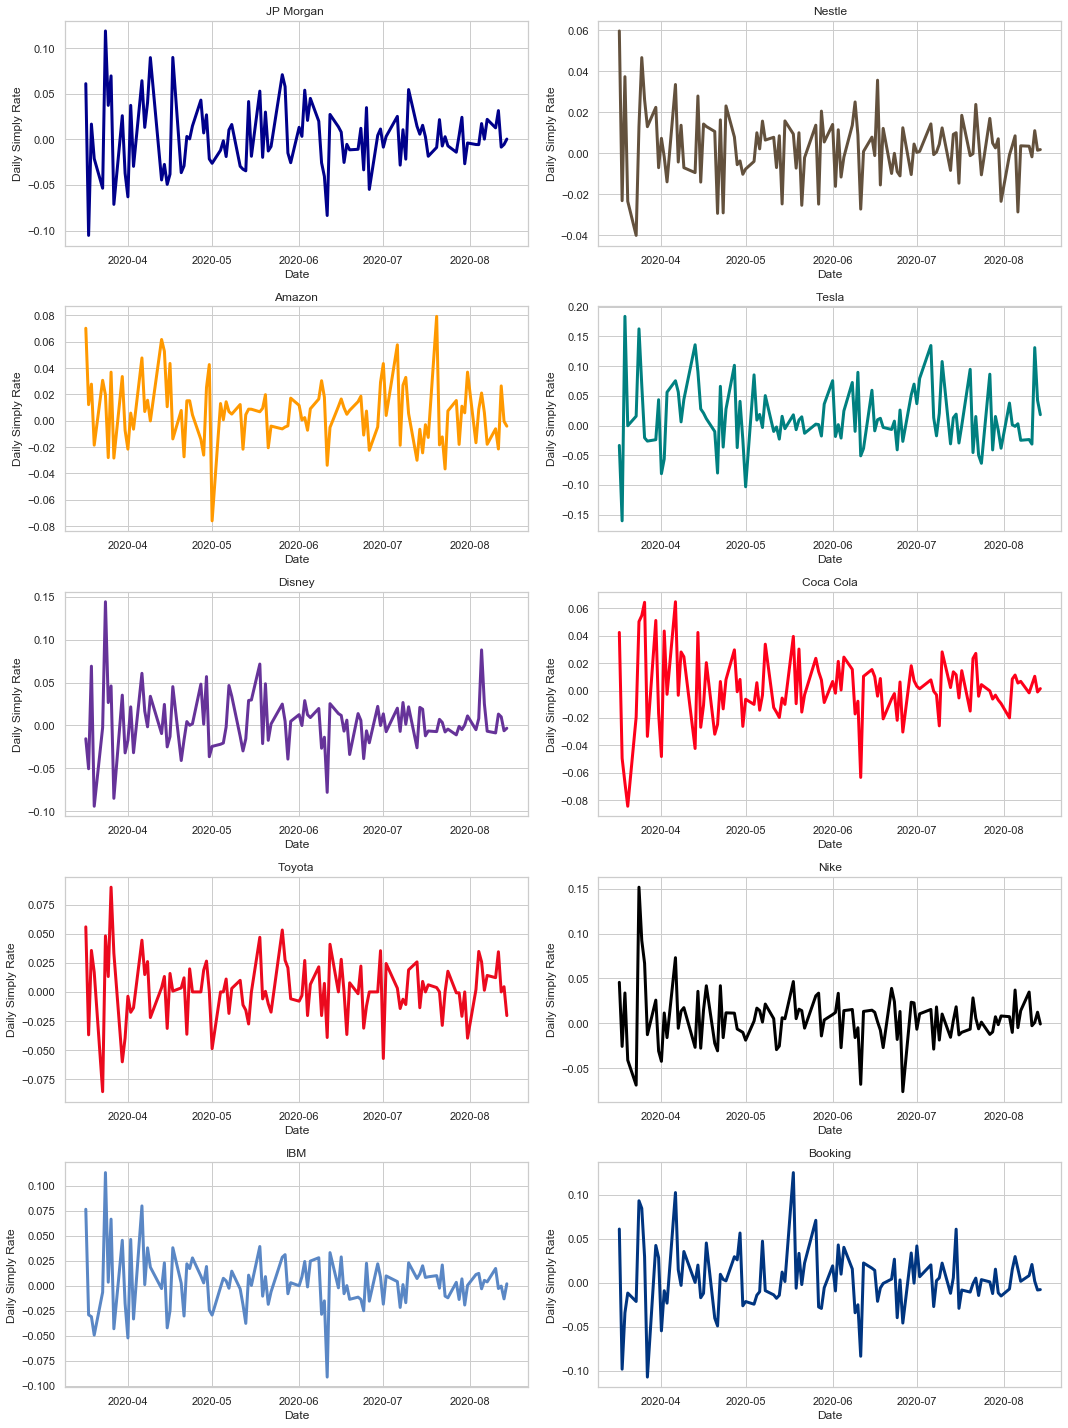

In [16]:
# Rate Return by company over the time
sns.set_style('whitegrid')
f = plt.figure(figsize=(15,20))
ax1 = f.add_subplot(521)
ax2 = f.add_subplot(522)
ax3 = f.add_subplot(523)
ax4 = f.add_subplot(524)
ax5 = f.add_subplot(525)
ax6 = f.add_subplot(526)
ax7 = f.add_subplot(527)
ax8 = f.add_subplot(528)
ax9 = f.add_subplot(529)
ax10 = f.add_subplot(5,2,10)

ax1.plot(daily_stock_return['JPM'], linewidth=3, color = '#00008B')
ax1.set_title("JP Morgan ")
ax1.set_ylabel("Daily Simply Rate")
ax1.set_xlabel("Date")

ax2.plot(daily_stock_return['NSRGF'], linewidth=3, color = '#63513D')
ax2.set_title("Nestle")
ax2.set_ylabel("Daily Simply Rate")
ax2.set_xlabel("Date")

ax3.plot(daily_stock_return['AMZN'], linewidth=3, color = '#FF9900')
ax3.set_title("Amazon")
ax3.set_ylabel("Daily Simply Rate")
ax3.set_xlabel("Date")

ax4.plot(daily_stock_return['TSLA'], linewidth=3, color = '#008080')
ax4.set_title("Tesla")
ax4.set_ylabel("Daily Simply Rate")
ax4.set_xlabel("Date")

ax5.plot(daily_stock_return['DIS'], linewidth=3, color = '#663399')
ax5.set_title("Disney")
ax5.set_ylabel("Daily Simply Rate")
ax5.set_xlabel("Date")

ax6.plot(daily_stock_return['KO'], linewidth=3, color = '#fe001a')
ax6.set_title("Coca Cola")
ax6.set_ylabel("Daily Simply Rate")
ax6.set_xlabel("Date")

ax7.plot(daily_stock_return['TOYOF'], linewidth=3, color = '#EB0A1E')
ax7.set_title("Toyota")
ax7.set_ylabel("Daily Simply Rate")
ax7.set_xlabel("Date")

ax8.plot(daily_stock_return['NKE'], linewidth=3, color = 'black')
ax8.set_title("Nike")
ax8.set_ylabel("Daily Simply Rate")
ax8.set_xlabel("Date")

ax9.plot(daily_stock_return['IBM'], linewidth=3, color = '#5A87C5')
ax9.set_title("IBM")
ax9.set_ylabel("Daily Simply Rate")
ax9.set_xlabel("Date")

ax10.plot(daily_stock_return['BKNG'], linewidth=3, color = '#003580')
ax10.set_title("Booking")
ax10.set_ylabel("Daily Simply Rate")
ax10.set_xlabel("Date")

plt.tight_layout()
plt.show()

In [17]:
# Mean Simple Return by stock. Tesla has the higher mean simple return in the period. 
#In the other hand, Coca Cola has the lowest mean simple return. 
mean_simple_return = daily_stock_return.mean()
mean_simple_return

Symbols
JPM      0.002235
NSRGF    0.002830
AMZN     0.006171
TSLA     0.013869
DIS      0.003524
KO       0.001047
TOYOF    0.001951
NKE      0.004871
IBM      0.002839
BKNG     0.003659
dtype: float64

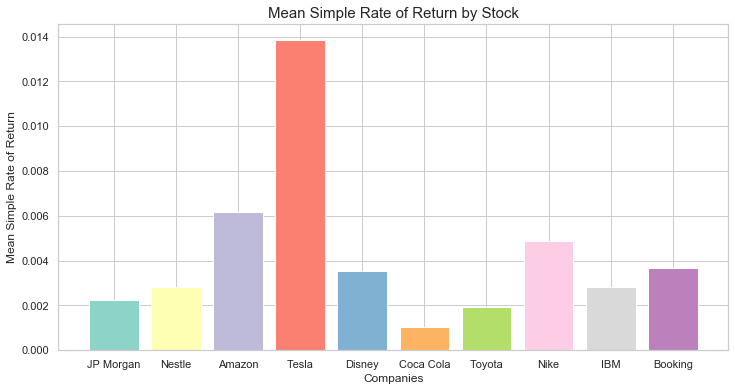

In [40]:
qualitative_colors = sns.color_palette('Set3',10)
sns.set_palette(qualitative_colors)
f = plt.figure(figsize=(12,6))
ax = f.add_subplot()
ax.bar(list(range(len(mean_simple_return))),mean_simple_return, color=qualitative_colors)
ax.set_xlabel('Companies')
ax.set_ylabel('Mean Simple Rate of Return')
ax.set_xticks(list(range(len(mean_simple_return))))
ax.set_xticklabels(full_name_stocks)
plt.title('Mean Simple Rate of Return by Stock', fontsize=15)
plt.savefig('mean_png')
plt.show()

In [19]:
# Variance
variance_stock = daily_stock_return.var()
variance_stock

Symbols
JPM      0.001325
NSRGF    0.000273
AMZN     0.000571
TSLA     0.002949
DIS      0.001069
KO       0.000642
TOYOF    0.000684
NKE      0.000912
IBM      0.000764
BKNG     0.001262
dtype: float64

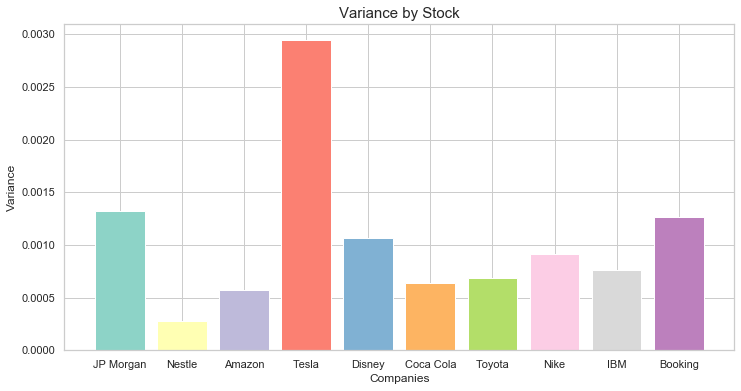

In [41]:
f = plt.figure(figsize=(12,6))
ax = f.add_subplot()
ax.bar(list(range(len(variance_stock))),variance_stock, color=qualitative_colors)
ax.set_xlabel('Companies')
ax.set_ylabel('Variance')
ax.set_xticks(list(range(len(mean_simple_return))))
ax.set_xticklabels(full_name_stocks)
plt.title('Variance by Stock', fontsize=15)
plt.savefig('variance_png')
plt.show()

In [21]:
# Standard Deviation. Tesla is the riskiest asset in the portfolio because it has the highest std. 
# In the other hand, Nestle is the less riskiest asset because it has the lowest std. 
std_stock = daily_stock_return.std()
std_stock

Symbols
JPM      0.036403
NSRGF    0.016529
AMZN     0.023891
TSLA     0.054306
DIS      0.032692
KO       0.025329
TOYOF    0.026155
NKE      0.030202
IBM      0.027645
BKNG     0.035520
dtype: float64

In [22]:
resume = pd.DataFrame([mean_simple_return,variance_stock,std_stock],index = ['Mean Return','Var','Std'])
resume

Symbols,JPM,NSRGF,AMZN,TSLA,DIS,KO,TOYOF,NKE,IBM,BKNG
Mean Return,0.002235,0.002830,0.006171,0.013869,0.003524,0.001047,0.001951,0.004871,0.002839,0.003659
Var,0.001325,0.000273,0.000571,0.002949,0.001069,0.000642,0.000684,0.000912,0.000764,0.001262
Std,0.036403,0.016529,0.023891,0.054306,0.032692,0.025329,0.026155,0.030202,0.027645,0.035520


In [23]:
#Covariance Matrix
cov_stock = daily_stock_return.cov()
cov_stock

Symbols,JPM,NSRGF,AMZN,TSLA,DIS,KO,TOYOF,NKE,IBM,BKNG
Symbols,,,,,,,,,,
JPM,0.001325,0.000171,0.000095,0.000571,0.000851,0.000674,0.000428,0.000811,0.000795,0.000975
NSRGF,0.000171,0.000273,0.000094,0.000273,0.000157,0.000181,0.000166,0.000232,0.000165,0.000202
AMZN,0.000095,0.000094,0.000571,0.000557,0.000212,0.000094,0.000072,0.000177,0.000211,0.000194
TSLA,0.000571,0.000273,0.000557,0.002949,0.000717,0.000269,0.000232,0.000599,0.000400,0.000689
DIS,0.000851,0.000157,0.000212,0.000717,0.001069,0.000528,0.000240,0.000687,0.000597,0.000841
KO,0.000674,0.000181,0.000094,0.000269,0.000528,0.000642,0.000199,0.000533,0.000561,0.000631
TOYOF,0.000428,0.000166,0.000072,0.000232,0.000240,0.000199,0.000684,0.000380,0.000312,0.000300
NKE,0.000811,0.000232,0.000177,0.000599,0.000687,0.000533,0.000380,0.000912,0.000605,0.000700
IBM,0.000795,0.000165,0.000211,0.000400,0.000597,0.000561,0.000312,0.000605,0.000764,0.000673


In [24]:
# Correlation Matrix. It's possible to see that doesn't exist a negative correlation between the diferents assets. 
corr_matrix = daily_stock_return.corr()
corr_matrix

Symbols,JPM,NSRGF,AMZN,TSLA,DIS,KO,TOYOF,NKE,IBM,BKNG
Symbols,,,,,,,,,,
JPM,1.000000,0.284950,0.109610,0.289025,0.715125,0.731122,0.449298,0.737735,0.789630,0.754283
NSRGF,0.284950,1.000000,0.238216,0.304437,0.291433,0.433035,0.385045,0.464068,0.361633,0.343430
AMZN,0.109610,0.238216,1.000000,0.429036,0.271064,0.155743,0.115087,0.244822,0.319590,0.228196
TSLA,0.289025,0.304437,0.429036,1.000000,0.404101,0.195264,0.163539,0.365308,0.266480,0.357369
DIS,0.715125,0.291433,0.271064,0.404101,1.000000,0.638057,0.281030,0.695774,0.660207,0.724138
KO,0.731122,0.433035,0.155743,0.195264,0.638057,1.000000,0.300492,0.697321,0.800516,0.701861
TOYOF,0.449298,0.385045,0.115087,0.163539,0.281030,0.300492,1.000000,0.481477,0.432033,0.322678
NKE,0.737735,0.464068,0.244822,0.365308,0.695774,0.697321,0.481477,1.000000,0.724415,0.652617
IBM,0.789630,0.361633,0.319590,0.266480,0.660207,0.800516,0.432033,0.724415,1.000000,0.685350


 ### Mean-Variance Portfolio Optimization

In [25]:
#Random Portfolios
random_portfolios = return_portfolios(mean_simple_return,cov_stock)
random_portfolios.head()

,Returns,Volatility,JPM Weight,NSRGF Weight,AMZN Weight,TSLA Weight,DIS Weight,KO Weight,TOYOF Weight,NKE Weight,IBM Weight,BKNG Weight
0,0.004107,0.022801,0.132544,0.228944,0.000036,0.096092,0.046644,0.029348,0.059200,0.109831,0.126106,0.171254
1,0.005185,0.022808,0.099824,0.163174,0.048687,0.209109,0.006522,0.159661,0.099374,0.133043,0.033431,0.047175
2,0.004222,0.023354,0.140044,0.169341,0.054815,0.121082,0.153273,0.156459,0.014874,0.006830,0.029702,0.153580
3,0.004840,0.021410,0.018530,0.079343,0.180480,0.100456,0.130359,0.059448,0.129346,0.157255,0.003446,0.141338
4,0.004486,0.022054,0.198651,0.150298,0.056338,0.158557,0.020737,0.089977,0.182526,0.058984,0.057811,0.026121


In [26]:
weights, returns, risks = optimal_portfolio(daily_stock_return[1:])

     pcost       dcost       gap    pres   dres
 0: -4.3958e-03 -1.0138e+00  1e+00  2e-16  4e+00
 1: -4.4211e-03 -2.3818e-02  2e-02  1e-16  7e-02
 2: -6.2263e-03 -1.3886e-02  8e-03  4e-17  2e-02
 3: -1.2615e-02 -1.5426e-02  3e-03  2e-15  1e-17
 4: -1.3688e-02 -1.3739e-02  5e-05  2e-16  6e-18
 5: -1.3721e-02 -1.3722e-02  5e-07  3e-16  9e-18
 6: -1.3722e-02 -1.3722e-02  5e-09  2e-16  7e-18
Optimal solution found.
     pcost       dcost       gap    pres   dres
 0: -4.3423e-03 -1.0137e+00  1e+00  2e-16  4e+00
 1: -4.3673e-03 -2.3708e-02  2e-02  9e-17  7e-02
 2: -6.1386e-03 -1.3706e-02  8e-03  7e-17  2e-02
 3: -1.2333e-02 -1.5050e-02  3e-03  3e-16  1e-17
 4: -1.3367e-02 -1.3419e-02  5e-05  1e-16  1e-17
 5: -1.3402e-02 -1.3403e-02  5e-07  1e-16  1e-17
 6: -1.3403e-02 -1.3403e-02  5e-09  1e-16  9e-18
Optimal solution found.
     pcost       dcost       gap    pres   dres
 0: -4.1731e-03 -1.0134e+00  1e+00  4e-16  4e+00
 1: -4.1974e-03 -2.3359e-02  2e-02  2e-16  7e-02
 2: -5.8662e-03 -1.3146e

'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.


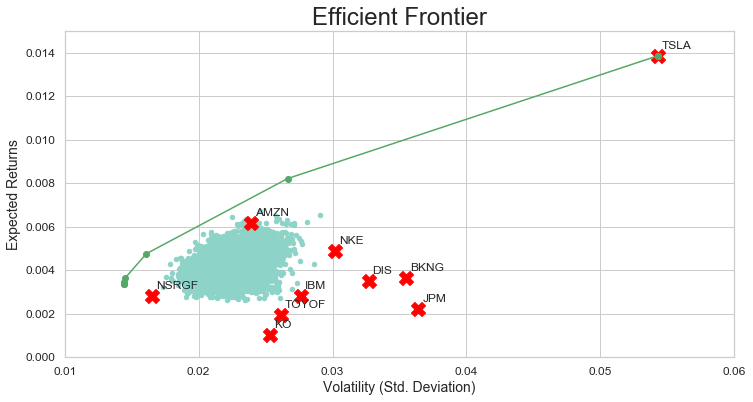

In [27]:
single_asset_std = np.sqrt(np.diagonal(cov_stock))

random_portfolios.plot.scatter(x='Volatility', y='Returns', fontsize=12, figsize=(12,6))
plt.plot(risks,returns, 'g-o')
plt.scatter(single_asset_std, mean_simple_return, marker='X',color='red',s=200)
plt.axis([0.01, 0.06, 0, 0.015])    
plt.ylabel('Expected Returns',fontsize=14)
plt.xlabel('Volatility (Std. Deviation)',fontsize=14)
plt.title('Efficient Frontier', fontsize=24)
for i, txt in enumerate(daily_stock_return.keys()):
    plt.annotate(txt, (single_asset_std[i], mean_simple_return[i]), size=12, xytext=(4,7), ha='left', textcoords='offset points')
plt.show()

In [28]:
random_portfolios.shape

(5000, 12)

In [30]:
min_volatility = random_portfolios.Volatility.min()
max_volatility = random_portfolios.Volatility.max()
print(min_volatility,max_volatility)

0.017342365765174256 0.02909386946424683


In [31]:
min_returns = random_portfolios.Returns.min()
max_returns = random_portfolios.Returns.max()
print(min_returns,max_returns)

0.002617390725249291 0.006717417162696792


### Option 1: Minimum Risk

In [32]:
portfolio_min_volatility = [random_portfolios.iloc[[i]] for i in range(5000) \
                            if (random_portfolios.Volatility[i] == min_volatility) \
                            and (random_portfolios.Returns[i] > min_returns)]
len(portfolio_min_volatility)

1

In [33]:
portfolio_min_volatility[0]

,Returns,Volatility,JPM Weight,NSRGF Weight,AMZN Weight,TSLA Weight,DIS Weight,KO Weight,TOYOF Weight,NKE Weight,IBM Weight,BKNG Weight
445,0.003251,0.017342,0.014805,0.252235,0.13248,0.033924,0.052341,0.213142,0.133876,0.030335,0.122838,0.014024


### Option 2: Maximum Return

In [34]:
portfolio_max_return = [random_portfolios.iloc[[i]] for i in range(5000) \
                            if (random_portfolios.Volatility[i] > min_volatility) \
                            and (random_portfolios.Returns[i] == max_returns)]
len(portfolio_max_return)

1

In [35]:
portfolio_max_return[0]

,Returns,Volatility,JPM Weight,NSRGF Weight,AMZN Weight,TSLA Weight,DIS Weight,KO Weight,TOYOF Weight,NKE Weight,IBM Weight,BKNG Weight
1564,0.006717,0.02459,0.062968,0.16244,0.188875,0.264302,0.065255,0.011665,0.011028,0.153179,0.02153,0.05876


### Option 3: Middle Risk and Return

In [36]:
portfolio_middle_return = [random_portfolios.iloc[[i]] for i in range(5000) \
                            if (random_portfolios.Volatility[i] < 0.0229) \
                            and (random_portfolios.Returns[i] > 0.006)]
len(portfolio_middle_return)

2

In [43]:
portfolio_middle_return[0]

,Returns,Volatility,JPM Weight,NSRGF Weight,AMZN Weight,TSLA Weight,DIS Weight,KO Weight,TOYOF Weight,NKE Weight,IBM Weight,BKNG Weight
624,0.006134,0.022845,0.047965,0.142944,0.241157,0.235219,0.11761,0.117816,0.025716,0.029563,0.016851,0.025159


In [38]:
portfolio_middle_return[1]

,Returns,Volatility,JPM Weight,NSRGF Weight,AMZN Weight,TSLA Weight,DIS Weight,KO Weight,TOYOF Weight,NKE Weight,IBM Weight,BKNG Weight
4383,0.00644,0.022484,0.034919,0.198304,0.232752,0.229341,0.000293,0.02811,0.016743,0.187185,0.068007,0.004346
